## Identifiability Test of Linear VAE on Synthetic Dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import ltcl
import numpy as np
from ltcl.datasets.sim_dataset import SimulationDataset
from ltcl.modules.lvae import AfflineVAESynthetic
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
use_cuda = True
device = torch.device("cuda:0" if use_cuda else "cpu")

In [5]:
data = SimulationDataset()
num_validation_samples = 2500
train_data, val_data = random_split(data, [len(data)-num_validation_samples, num_validation_samples])
train_loader = DataLoader(train_data, batch_size=12800, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_data, batch_size=16, shuffle=False, pin_memory=True)

In [6]:
model = AfflineVAESynthetic(4,4,2).to(device)

/home/cmu_wyao/projects/ltcl/ltcl/modules/components/beta.py:166: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


### Warm start spline flow

Do not run this block if already warm-started

In [ ]:
batch_size = 64
spline_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.spline.parameters()), 
                                    lr=1e-3,
                                    weight_decay=0.0)
# Warm-start the prior to standard normal dist
for step in range(5000):
    latent_size = 4
#     y_t = torch.normal(0, 1, size=(batch_size, latent_size))
    y_t = torch.distributions.laplace.Laplace(0,1).rsample((batch_size, latent_size))
    dataset = y_t.to(device)
    spline_optimizer.zero_grad()
    z, logabsdet = model.spline(dataset)
    logp = model.spline.base_dist.log_prob(z) + logabsdet
    loss = -torch.mean(logp)
    loss.backward(retain_graph=True)
    spline_optimizer.step()
# This checkpoint will be loaded in lvae.py
torch.save(model.spline.state_dict(), "/home/cmu_wyao/spline.pth")

### Load model checkpoint

In [7]:
model = model.load_from_checkpoint("/home/cmu_wyao/checkpoints/linear_vae/lightning_logs/version_53/checkpoints/epoch=42-step=330489.ckpt",
                                   input_dim = 4, z_dim=4, lag=2)

/home/cmu_wyao/projects/ltcl/ltcl/modules/components/beta.py:166: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


In [8]:
model.eval()

AfflineVAESynthetic(
  (net): BetaVAE_MLP(
    (encoder): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): LeakyReLU(negative_slope=0.2)
      (8): Linear(in_features=128, out_features=8, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): LeakyReLU(negative_slope=0.2)

In [9]:
model.to('cpu')

AfflineVAESynthetic(
  (net): BetaVAE_MLP(
    (encoder): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): LeakyReLU(negative_slope=0.2)
      (8): Linear(in_features=128, out_features=8, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): LeakyReLU(negative_slope=0.2)

### Compute permutation and sign flip

In [10]:
for batch in train_loader:
    break
batch_size = batch['xt'].shape[0]

In [11]:
x_recon, mu, logvar, z = model.forward(batch)
mu = mu.view(batch_size, -1, 4)
A = mu[:,0,:].detach().cpu().numpy()
B = batch['yt'][:,0,:].detach().cpu().numpy()
C = np.zeros((4,4))
for i in range(4):
    C[i] = -np.abs(np.corrcoef(B, A, rowvar=False)[i,4:])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(C)
A = A[:, col_ind]
mask = np.ones(4)
for i in range(4):
    if np.corrcoef(B, A, rowvar=False)[i,4:][i] > 0:
        mask[i] = -1
print("Permutation:",col_ind)
print("Sign Flip:", mask)

Permutation: [2 0 3 1]
Sign Flip: [ 1. -1.  1.  1.]


Text(0.5, 1.0, 'MCC=0.96')

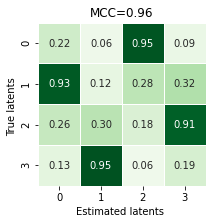

In [53]:
fig = plt.figure(figsize=(3,3))
sns.heatmap(-C, vmin=0, vmax=1, annot=True, fmt=".2f", linewidths=.5, cbar=False, cmap='Greens')
plt.xlabel("Estimated latents ") 
plt.ylabel("True latents ") 
plt.title("MCC=0.96")

In [12]:
# Permute column here
mu = mu[:,:,col_ind]
# Flip sign here
mu = mu * torch.Tensor(mask, device=mu.device).view(1,1,4)
mu = -mu

Text(0.5, 1.0, 'Current latent variable $z_t$')

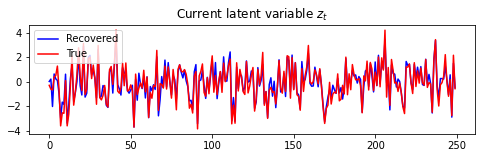

In [13]:
fig = plt.figure(figsize=(8,2))
col = 0
plt.plot(mu[:250,-1,col].detach().cpu().numpy(), color='b', label='Recovered')
plt.plot(batch['yt_'].squeeze()[:250,col].detach().cpu().numpy(), color='r', label="True")
plt.legend()
plt.title("Current latent variable $z_t$")

Text(0.5, 1.0, 'Past latent variable $z_l$')

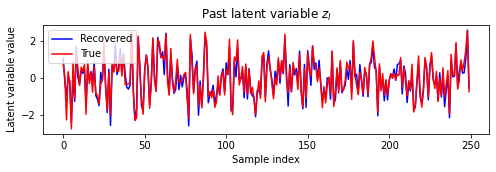

In [14]:
fig = plt.figure(figsize=(8,2))
col = 3
l = 1
plt.plot(batch['yt'].squeeze()[:250,l,col].detach().cpu().numpy(), color='b', label='Recovered')
plt.plot(mu[:,:-1,:][:250,l,col].detach().cpu().numpy(), color='r', label="True")
plt.xlabel("Sample index")
plt.ylabel("Latent variable value")
plt.legend()
plt.title("Past latent variable $z_l$")

/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Learned noise prior by spline flow')

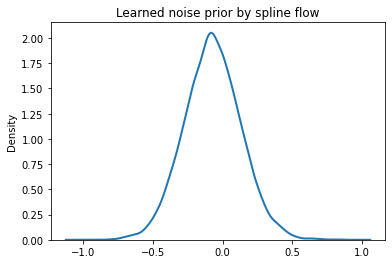

In [15]:
eps = model.sample(batch["xt"].cpu())
eps = eps.detach().cpu().numpy()
component_idx = 3
sns.distplot(eps[:,component_idx], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2});
plt.title("Learned noise prior by spline flow")

### System identification (causal discovery)

In [16]:
from ltcl.modules.components.base import GroupLinearLayer
trans_func = GroupLinearLayer(din = 4, 
                              dout = 4,
                              num_blocks = 2,
                              diagonal = False)
opt = torch.optim.Adam(trans_func.parameters(),lr=0.01)
lossfunc = torch.nn.L1Loss()

In [18]:
max_iters = 2
counter = 0
for step in range(max_iters):
    for batch in train_loader:
        batch_size = batch['yt'].shape[0]
        x_recon, mu, logvar, z = model.forward(batch)
        mu = mu.view(batch_size, -1, 4)
        # Fix permutation before training
        mu = mu[:,:,col_ind]
        # Fix sign flip before training
        mu = mu * torch.Tensor(mask, device=mu.device).view(1,1,4)
        mu = -mu
        pred = trans_func(mu[:,:-1,:]).sum(dim=1)
        true = mu[:,-1,:]
        loss = lossfunc(pred, true) #+ torch.mean(adaptive.lossfun((pred - true)))

        opt.zero_grad()
        loss.backward()
        opt.step()
        if counter % 100 == 0:
            print(loss.item())
        counter += 1

0.8014541864395142
0.036980997771024704


In [30]:
trans_func.w[0]

tensor([[-0.2583, -0.5369, -0.7054,  0.0596],
        [-0.8104,  0.8442,  0.3742, -0.4689],
        [-0.5304, -0.4326,  0.4335, -0.4999],
        [-0.1527,  0.0948, -0.3268,  0.3688]], grad_fn=<SelectBackward>)

In [28]:
model.trans_func.w[0][:, col_ind]

tensor([[-0.8013, -0.8491,  0.3724, -0.4563],
        [ 0.1540,  0.1015,  0.3185, -0.3545],
        [ 0.2558, -0.5247,  0.7026, -0.0649],
        [ 0.5200, -0.4260, -0.4180,  0.4755]], grad_fn=<IndexBackward>)

In [19]:
B2 = trans_func.w[0].detach().cpu().numpy()
B1 = trans_func.w[1].detach().cpu().numpy()
BB2 = np.load("/home/cmu_wyao/projects/data/linear_nongaussian/W2.npy")
BB1 = np.load("/home/cmu_wyao/projects/data/linear_nongaussian/W1.npy")

In [20]:
b = np.concatenate((B1,B2), axis=0)
bb = np.concatenate((BB1,BB2), axis=0)
b = b / np.linalg.norm(b, axis=0).reshape(1, -1)
bb = bb / np.linalg.norm(bb, axis=0).reshape(1, -1)
pred = (b / np.linalg.norm(b, axis=0).reshape(1, -1)).reshape(-1)
true = (bb / np.linalg.norm(bb, axis=0).reshape(1, -1)).reshape(-1)

Text(0, 0.5, 'Ground truth weight')

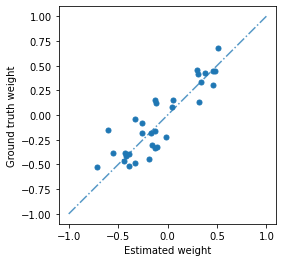

In [21]:
fig, ax = plt.subplots()
ax.scatter(pred, true, s=25, cmap=plt.cm.coolwarm, zorder=10)
lims = [-1,1
]

# now plot both limits against eachother
ax.plot(lims, lims, '-.', alpha=0.75, zorder=0)
ax.set_aspect('equal')
# ax.set_xlim(lims)
# ax.set_ylim(lims)
ax.set_xlabel("Estimated weight")
ax.set_ylabel("Ground truth weight")

In [22]:
def amari_distance(r):
    p = r.shape[0]
    abs_r = np.abs(r)
    l = np.sum(np.sum(abs_r, axis=1, keepdims=True) / np.max(abs_r, axis=1, keepdims=True) - 1, axis=0)
    r = np.sum(np.sum(abs_r, axis=0, keepdims=True) / np.max(abs_r, axis=0, keepdims=True) - 1, axis=1)
    return 1/(2*p*(p-1)) * (l+r)

In [23]:
am2 = amari_distance(np.linalg.inv(B2) @ BB2)
am1 = amari_distance(np.linalg.inv(B1) @ BB1)
print(f"Amari index: {am2[0], am1[0]}")

Amari index: (0.3405403037888913, 0.28346081140939794)


In [24]:
from sklearn.metrics import r2_score
r2_score(pred,true)

0.7561937071282262